<a href="https://colab.research.google.com/github/seemab21/Thesis_Transformer_model/blob/main/Transformer_Model_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Dependencies**

In [1]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


# **Config**

In [2]:
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['EL', 'PD']
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'right acceleration X[g]',
    'right acceleration Y[g]',
    'right acceleration Z[g]'
]
label_map = {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}

# **Data Loading & Frame Building**

In [3]:
# Function to process a single file
def process_file(filepath):
    # Read the data from the Excel file
    data = pd.read_excel(filepath)


    # Drop rows with NaNs in relevant columns
    data = data.dropna(subset=feature_cols + ['Event- Label level 2- Left Foot'])


    # Normalize selected accelerometer columns
    scaler = StandardScaler()
    data[feature_cols] = scaler.fit_transform(data[feature_cols])


    # Map activity labels to numerical values
    data['label'] = data['Event- Label level 2- Left Foot'].map(label_map)

    # Drop rows where label mapping failed (NaN labels)
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)


    # Extract frames and their majority labels
    frames = []
    labels = []
    for i in range(0, len(data) - frame_size + 1, frame_size):
        segment = data.iloc[i:i + frame_size]
        frame = segment[feature_cols].values.flatten()  # Flatten to 1D array

        label = np.bincount(segment['label']).argmax()  # Majority label in frame
        frames.append(frame)
        labels.append(label)

    return frames, labels


# Function to load data from multiple groups and preprocess it
def load_all_group_data(root_dir, groups):
    all_frames = []
    all_labels = []
    skipped_files_count = 0
    a_frame = {i: [] for i in range(frame_size * len(feature_cols))}  # Initialize for the flattened frames
    a_frame['label'] = []  # For storing labels

    # Loop through each group folder (EL, PD, etc.)
    for group in groups:
        group_path = os.path.join(root_dir, group)

        # Loop through all Excel files in the group folder
        for file_name in os.listdir(group_path):
            if file_name.endswith('.xlsx'):
                filepath = os.path.join(group_path, file_name)

                try:
                    # Process each file to extract frames and labels
                    frames, labels = process_file(filepath)
                    all_frames.extend(frames)
                    all_labels.extend(labels)

                    # Add frames and labels to the dictionary
                    for frame, label in zip(frames, labels):
                        for i, val in enumerate(frame):
                            a_frame[i].append(val)
                        a_frame['label'].append(label)

                except KeyError as e:
                    # Handle missing columns in the file
                    print(f"File skipped due to missing columns: {filepath}")
                    print(f"Missing columns error: {e}")
                    skipped_files_count += 1
                    continue  # Skip to the next file

    # Convert lists to numpy arrays
    all_frames = np.array(all_frames)
    all_labels = np.array(all_labels, dtype=int)

    print(f"Total files skipped due to missing columns: {skipped_files_count}")

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(a_frame)

    return all_frames, all_labels, df



# Function to compute class weights for imbalanced datasets
# def compute_class_weights(labels):
#    label_counts = np.bincount(labels)
#    total = len(labels)

#    # Class weight formula to handle class imbalance
#   weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]

#    return torch.tensor(weights, dtype=torch.float32)

def compute_class_weights(labels, num_classes):
    classes = np.arange(num_classes)
    w = compute_class_weight(class_weight='balanced',
                             classes=classes,
                             y=labels)
    return torch.tensor(w, dtype=torch.float32)

In [4]:
# Load and preprocess data
frames, labels, df = load_all_group_data(root_dir, groups)
num_classes = 4
class_weights = compute_class_weights(labels, num_classes)

# Summary of the dataset
print("\n--- Data Summary ---")
print("Frames shape:", frames.shape)        # (num_frames, 300)
print("Labels shape:", labels.shape)        # (num_frames,)
print("Class Weights:", class_weights)

# Display the DataFrame with the frames
print("\n--- DataFrame with frames ---")
print(df.head())
print("Number of features:", len(df.columns))
print("Original DataFrame shape:", df.shape)

print(f"Total number of samples (frames): {frames.shape[0]}")
print(f"Frame size (flattened): {frames.shape[1]}")
print(f"Total number of labels: {labels.shape[0]}")
print(f"Unique labels and counts: {np.unique(labels, return_counts=True)}")

#Check for any remaining NaNs
print(f"\n Any NaN values remaining? {df.isna().any().any()}")

File skipped due to missing columns: /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]']
Total files skipped due to missing columns: 1

--- Data Summary ---
Frames shape: (3090, 600)
Labels shape: (3090,)
Class Weights: tensor([1.3365, 4.7685, 0.5335, 0.8564])

--- DataFrame with frames ---
          0         1         2         3         4         5         6  \
0  0.270147 -0.156284 -0.387857  0.215557 -0.047716 -0.341798  0.260864   
1  0.293355 -0.180156 -0.350676  0.229037 -0.028921 -0.344688  0.306248   
2  0.724503  0.371077 -0.018702  0.364372 -0.005706 -0.437167  0.573910   
3  0.082422  1.941223  2.371513  0.134139  0.094901 -0.048465  0.927183   
4 -0.346663  0.450289  0.649230 -0.205009 -2.939856  1.318498 -0.434337   

          7         8         9  ...       591       592       

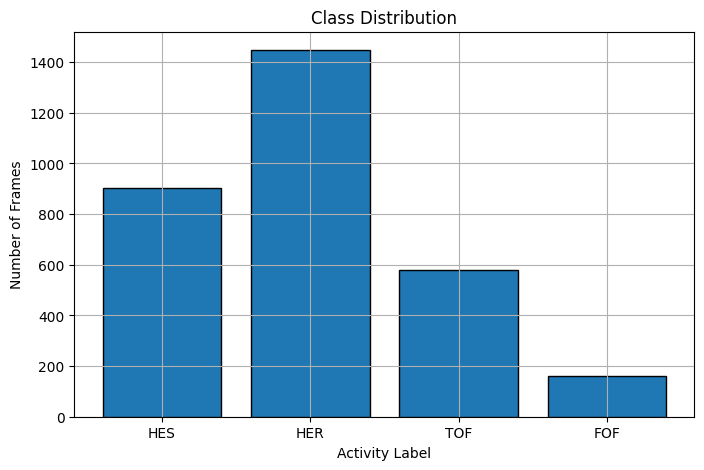

In [5]:
# Mapping back label index to activity name
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[l] for l in labels]

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.hist(label_names, bins=np.arange(len(label_map)+1)-0.5, edgecolor='black', rwidth=0.8)
plt.xticks(ticks=range(len(label_map)), labels=[inv_label_map[i] for i in range(len(label_map))])
plt.xlabel('Activity Label')
plt.ylabel('Number of Frames')
plt.title('Class Distribution')
plt.grid(True)
plt.show()

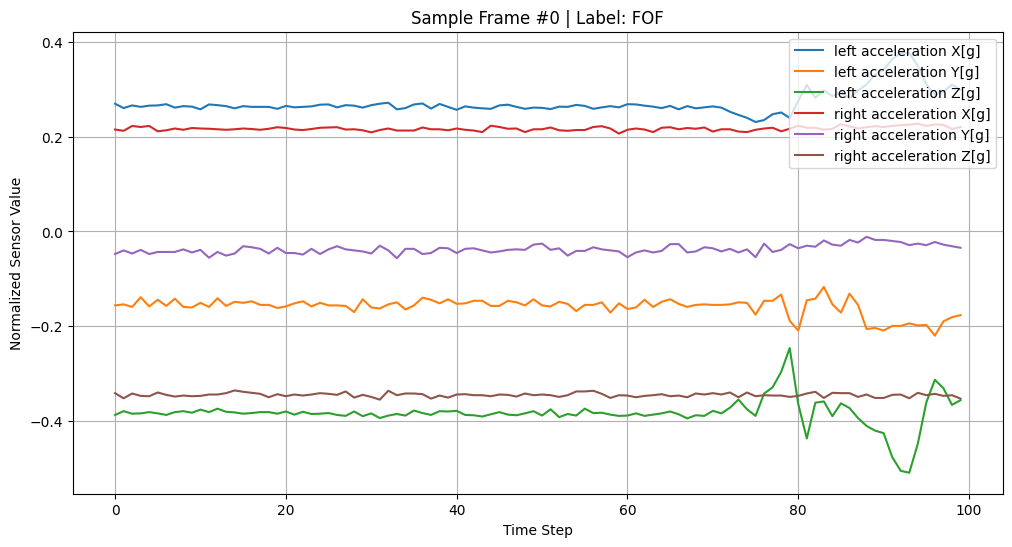

In [6]:
# Choose a sample frame index
sample_index = 0  # Change this to see other samples
sample_frame = frames[sample_index].reshape(frame_size, len(feature_cols))

# Plot each sensor signal in the sample frame
plt.figure(figsize=(12, 6))
for i, col in enumerate(feature_cols):
    plt.plot(range(frame_size), sample_frame[:, i], label=col)

plt.xlabel('Time Step')
plt.ylabel('Normalized Sensor Value')
plt.title(f'Sample Frame #{sample_index} | Label: {inv_label_map[labels[sample_index]]}')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# **Dataset & DataLoader**

In [7]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 6)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
      return len(self.Y)
    def __getitem__(self, idx):
      return self.X[idx], self.Y[idx]

def prepare_dataloaders(x, y, batch_size=32):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    return {
        'train': DataLoader(IMUDataset(x_train, y_train), batch_size=batch_size, shuffle=True),
        'val': DataLoader(IMUDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    }


# **Transformer Model**

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.3, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, drop_prob=0.3):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # Multi-head self-attention with residual and norm
        _x = x
        x = self.attn(x)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Feed-forward network with residual and norm
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers, drop_prob=0.3):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden, drop_prob=drop_prob)
            for _ in range(n_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


###### Classification head missing


In [9]:
class ClassificationHead(nn.Module):
    def __init__(self,d_model, seq_len , n_classes: int = 2):

      super().__init__()
      self.norm = nn.LayerNorm(d_model)
      self.seq = nn.Sequential( nn.Flatten() , nn.Linear(d_model * seq_len , 512),
                               nn.ReLU(),nn.Linear(512, 256),
                               nn.ReLU(),nn.Linear(256, 128),
                                nn.ReLU(),nn.Linear(128, n_classes)
                                )

    def forward(self,x):
      x = self.norm(x)
      x = self.seq(x)
      return x

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, d_model=128, n_head=4, n_layers=4, seq_len=100, hidden=128, num_classes=4, drop_prob=0.3):
        super().__init__()

        # Input projection layer
        self.input_proj = nn.Linear(6, d_model)

        # Positional encoding layer
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder: Adding dropout to each EncoderLayer
        self.encoder = nn.Sequential(*[
            EncoderLayer(d_model, n_head, hidden, drop_prob) for _ in range(n_layers)
        ])

        self.classifier = ClassificationHead(
            d_model=d_model, seq_len=seq_len, n_classes=num_classes
        )

    def forward(self, x):
        # Project input to d_model
        x = self.input_proj(x)

        # Apply positional encoding
        x = self.pos_enc(x)

        # Pass through the encoder layers
        x = self.encoder(x)

        # Pass through the classifier
        return self.classifier(x)


class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)

        return torch.matmul(attn, v), attn



class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

        self.eps = 1e-6


    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, drop_prob=0.3):
        super().__init__()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()

        self.n_head = n_head
        self.attn = ScaleDotProductAttention()

        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape

        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)

        return self.out_proj(out)

# **Training & Evaluation**

In [12]:
def calc_loss(outputs, targets, class_weights, metrics):
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss



def train_model(model, dataloaders, optimizer, weights, epochs, patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0
    stop_training = False

    # Initialize the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(inputs)
                    loss = calc_loss(out, labels, weights, metrics)
                    if phase == 'train':
                      loss.backward();
                      optimizer.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(" Best model updated!")
                else:
                    epochs_no_improve += 1

                # Step the scheduler with the validation loss after each epoch
                if scheduler:
                     scheduler.step(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                stop_training = True
                break

        if stop_training:
            break


    model.load_state_dict(best_model_wts)
    return model, history

def plot_metrics(history):
    epochs = range(1, len(history['train']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

def evaluate_model(model, dataloader, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()



In [13]:
# Hyperparameters
num_classes = 4
learning_rate = 0.000001
batch_size = 8
epochs = 100
patience = 15

In [14]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Run Everything**

File skipped due to missing columns: /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]']
Total files skipped due to missing columns: 1

Epoch 1/100
------------------------------
Train Loss: 1.3835 | Accuracy: 46.80%
 Best model updated!
Val Loss: 1.3714 | Accuracy: 46.93%

Epoch 2/100
------------------------------
Train Loss: 1.3751 | Accuracy: 46.93%
 Best model updated!
Val Loss: 1.3621 | Accuracy: 55.99%

Epoch 3/100
------------------------------
Train Loss: 1.3643 | Accuracy: 51.21%
 Best model updated!
Val Loss: 1.3509 | Accuracy: 51.94%

Epoch 4/100
------------------------------
Train Loss: 1.3567 | Accuracy: 56.67%
 Best model updated!
Val Loss: 1.3397 | Accuracy: 50.49%

Epoch 5/100
------------------------------
Train Loss: 1.3461 | Accuracy: 56.96%
 Best model updated!
Val Loss: 1.

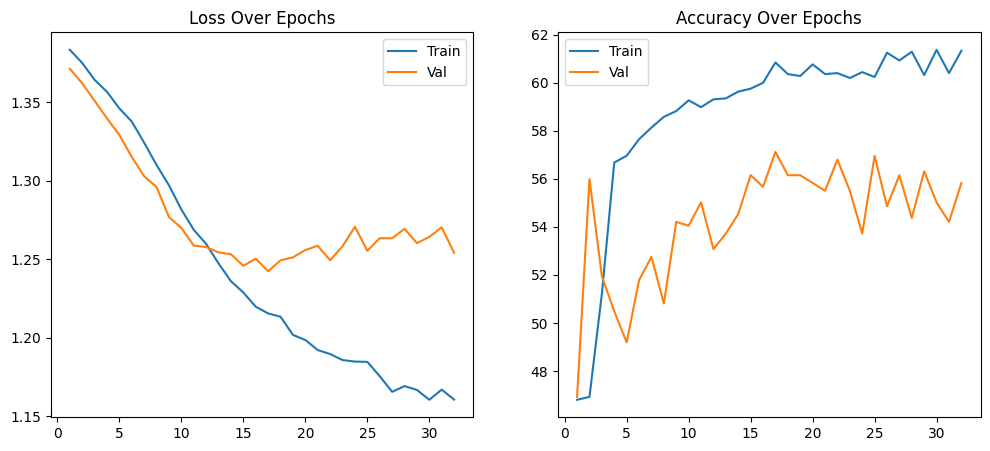

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Validation Metrics:
Accuracy : 57.12%
Precision: 55.48%
Recall   : 57.12%
F1 Score : 53.15%
Confusion matrix saved to: /content/drive/MyDrive/IMU/confusion_matrix_ActivityRecognition.png


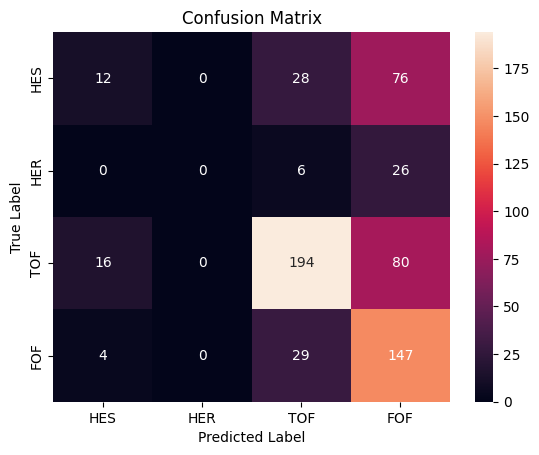

In [15]:
frames, labels, df = load_all_group_data(root_dir, groups)

# Prepare dataloaders
dataloaders = prepare_dataloaders(frames, labels, batch_size=batch_size)

# Initialize model and optimizer
model = TransformerModel().to(device)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Train the model
trained_model, history = train_model(model, dataloaders, optimizer, class_weights, epochs, patience)

# Plot training/validation metrics
plot_metrics(history)

# Evaluate final model performance and save confusion matrix
evaluate_model(trained_model, dataloaders['val'], save_path="/content/drive/MyDrive/IMU/confusion_matrix_ActivityRecognition.png")

# Save model
torch.save(trained_model.state_dict(), f"{root_dir}/transformer_model_activity_recognition.pth")

